# CheXScan Ensemble Experiments

## Libraries

In [1]:
import tensorflow as tf
from keras import datasets, layers, models
from keras.optimizers import Adam
from keras.optimizers import Adam as LegacyAdam
from keras.layers import Input, Average

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam as LegacyAdam
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Checking GPU usage

In [2]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices()

print("Available physical devices:")
for device in physical_devices:
    print(device)

# Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available")
    # Additional information about each GPU device
    for gpu in gpu_devices:
        print("GPU device name:", gpu.name)
else:
    print("GPU is NOT available, using CPU")


Available physical devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU is available
GPU device name: /physical_device:GPU:0


In [3]:
# Get the list of available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Check if there are GPUs available
if gpus:
    # Set memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPU:", gpu)
else:
    print("No GPUs found.")

Memory growth set for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Limit TensorFlow to use a fraction of GPU memory
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)  
# Change 0.5 to the desired fraction
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

## Constants

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CLASSES = ['normal', 'pneumonia', 'tuberculosis']
NUM_CLASSES = len(CLASSES)
EPOCHS = 2

## Dataset

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/THESIS/chexscan/exp/data/train_data',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/THESIS/chexscan/exp/data/test_data',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 240 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


## Data Preprocessing and Augmentation

img_size = (IMAGE_SIZE, IMAGE_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip = True,
    rotation_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
    'C:/THESIS/chexscan/exp/data/train_data',
    target_size=img_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_generator = valid_datagen.flow_from_directory(
    'C:/THESIS/chexscan/exp/data/test_data',
    target_size=img_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

# Convert DirectoryIterator objects to TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 299, 299, 3], [None, NUM_CLASSES])
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: valid_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 299, 299, 3], [None, NUM_CLASSES])
)

## Training Parameters

In [7]:
loss_function = 'sparse_categorical_crossentropy'
optimizer = Adam(learning_rate=0.0001)
num_epochs = EPOCHS

## Evaluation Functions

In [8]:
def evaluate_model(model, valid_dataset):
    predictions = []
    true_labels = []
    for images, labels in valid_dataset:
        preds = model.predict(images)
        predictions.extend(np.argmax(preds, axis=1))
        true_labels.extend(labels.numpy())
    return true_labels, predictions

In [9]:
def plot_history_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

## AlexNet

Epoch 1/2
8/8 [==============================] - 8s 370ms/step - loss: 16.3995 - accuracy: 0.3042 - val_loss: 1.8803 - val_accuracy: 0.5667
Epoch 2/2
1/1 [==============================] - 0s 75ms/step
AlexNet Accuracy: 0.5333333333333333


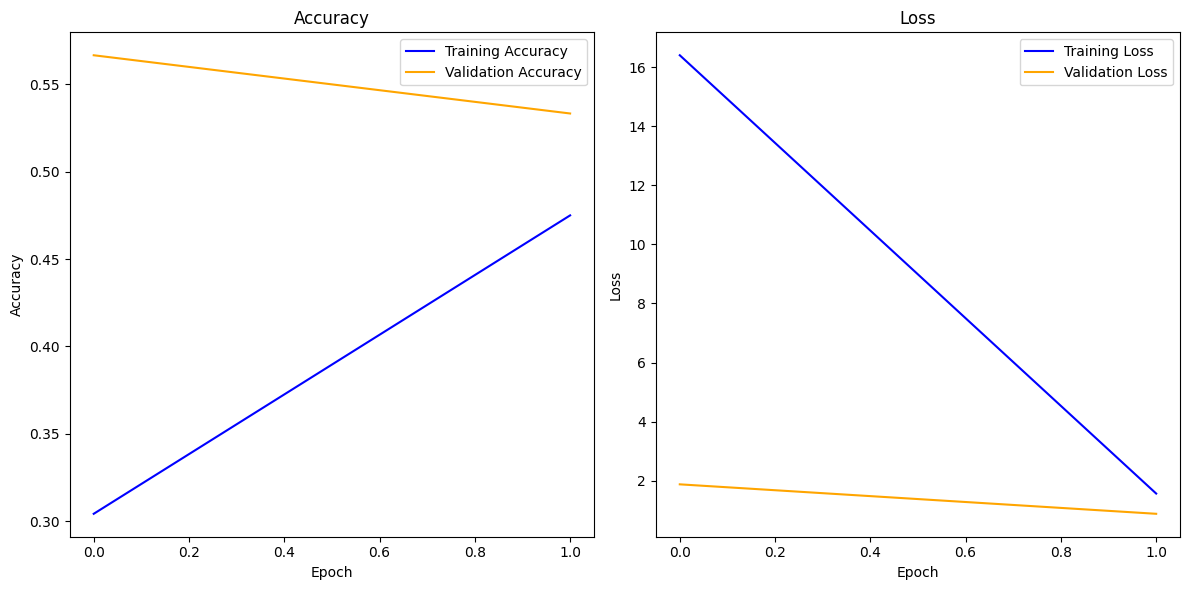

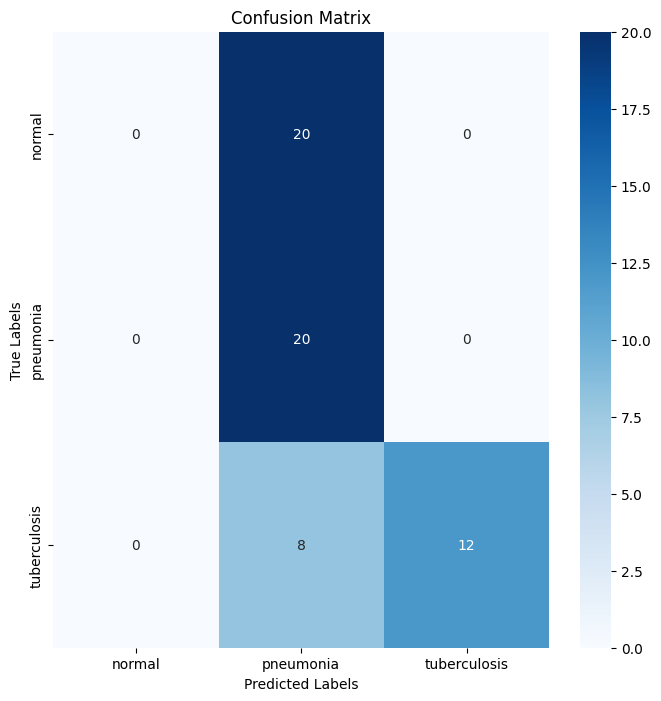

Classification Report for AlexNet:
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        20
   pneumonia       0.42      1.00      0.59        20
tuberculosis       1.00      0.60      0.75        20

    accuracy                           0.53        60
   macro avg       0.47      0.53      0.45        60
weighted avg       0.47      0.53      0.45        60



c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [15]:
alexnet_model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(299, 299, 3)),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Define the optimizer
optimizer = LegacyAdam(learning_rate=0.0001)

# Compile AlexNet model with legacy optimizer
alexnet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Train AlexNet model with early stopping
history_alexnet = alexnet_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=[early_stopping])

# Evaluate AlexNet model
true_labels_alexnet, predicted_labels_alexnet = evaluate_model(alexnet_model, valid_dataset)
accuracy_alexnet = accuracy_score(true_labels_alexnet, predicted_labels_alexnet)
print("AlexNet Accuracy:", accuracy_alexnet)

# Plot history metrics for AlexNet
plot_history_metrics(history_alexnet)

# Plot confusion matrix for AlexNet
plot_confusion_matrix(true_labels_alexnet, predicted_labels_alexnet, CLASSES)

# Display classification report for AlexNet
print("Classification Report for AlexNet:")
print(classification_report(true_labels_alexnet, predicted_labels_alexnet, target_names=CLASSES))


## DenseNet-121

In [16]:
from keras.applications import DenseNet121

# Load pre-trained DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Define top layers for the model
densenet_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Combine base model with top layers
densenet_model = tf.keras.Model(inputs=densenet_model.input, outputs=densenet_top(densenet_model.output))

# Define the optimizer
optimizer = LegacyAdam(learning_rate=0.0001)

# Compile DenseNet121 model with legacy optimizer
densenet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Train DenseNet121 model with early stopping
history_densenet = densenet_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=[early_stopping])

# Evaluate DenseNet121 model
true_labels_densenet, predicted_labels_densenet = evaluate_model(densenet_model, valid_dataset)
accuracy_densenet = accuracy_score(true_labels_densenet, predicted_labels_densenet)
print("DenseNet121 Accuracy:", accuracy_densenet)

# Plot history metrics for DenseNet121
plot_history_metrics(history_densenet)

# Plot confusion matrix for DenseNet121
plot_confusion_matrix(true_labels_densenet, predicted_labels_densenet, CLASSES)

# Display classification report for DenseNet121
print("Classification Report for DenseNet121:")
print(classification_report(true_labels_densenet, predicted_labels_densenet, target_names=CLASSES))


Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2_block6_0_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\macas\AppData\Local\Temp\ipykernel_12296\4245728650.py", line 27, in <module>
      history_densenet = densenet_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=[early_stopping])
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model/conv2_block6_0_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,224,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2_block6_0_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27696]

## ResNet-50

In [ ]:
from keras.applications import ResNet50

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Define top layers for the model
resnet_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Combine base model with top layers
resnet_model = tf.keras.Model(inputs=resnet_model.input, outputs=resnet_top(resnet_model.output))

# Build optimizer with the full list of trainable variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Compile ResNet50 model with Adam optimizer
resnet_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train ResNet50 model with early stopping
history_resnet = resnet_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=[early_stopping])

# Evaluate ResNet50 model
true_labels_resnet, predicted_labels_resnet = evaluate_model(resnet_model, valid_dataset)
accuracy_resnet = accuracy_score(true_labels_resnet, predicted_labels_resnet)
print("ResNet50 Accuracy:", accuracy_resnet)

# Plot history metrics for ResNet50
plot_history_metrics(history_resnet)

# Plot confusion matrix for ResNet50
plot_confusion_matrix(true_labels_resnet, predicted_labels_resnet, CLASSES)

# Display classification report for ResNet50
print("Classification Report for ResNet50:")
print(classification_report(true_labels_resnet, predicted_labels_resnet, target_names=CLASSES))


Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model_6/conv3_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell
      result = self._run_cell(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell
      result = runner(coro)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\macas\AppData\Local\Temp\ipykernel_17248\997162585.py", line 27, in <module>
      history_resnet = resnet_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=[early_stopping])
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_6/conv3_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,38,38,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_6/conv3_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_86087]

## VGG-16

Epoch 1/2
8/8 [==============================] - 35s 2s/step - loss: 1.8108 - accuracy: 0.4958 - val_loss: 0.7835 - val_accuracy: 0.7000
Epoch 2/2
1/1 [==============================] - 0s 104ms/step
VGG16 Accuracy: 0.6833333333333333


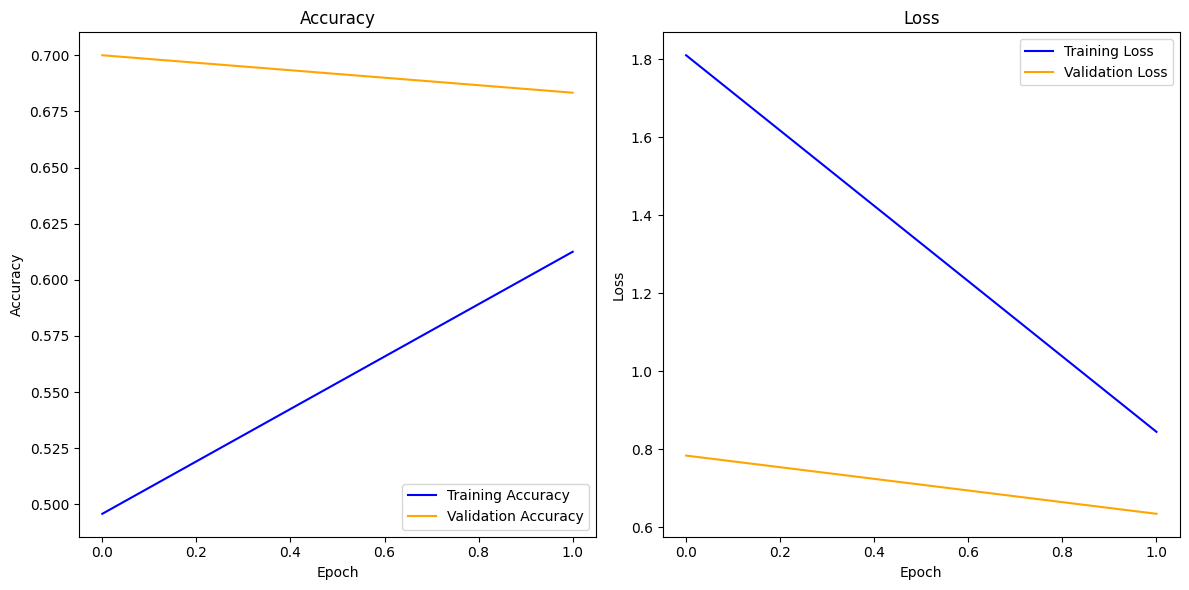

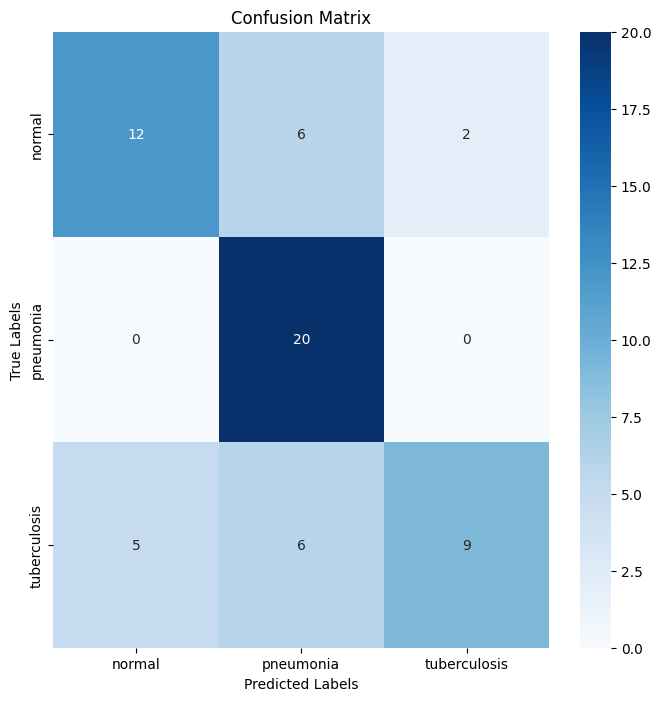

Classification Report for VGG16:
              precision    recall  f1-score   support

      normal       0.71      0.60      0.65        20
   pneumonia       0.62      1.00      0.77        20
tuberculosis       0.82      0.45      0.58        20

    accuracy                           0.68        60
   macro avg       0.72      0.68      0.67        60
weighted avg       0.72      0.68      0.67        60



In [12]:
from keras.applications import VGG16

# Load pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define top layers for the model
vgg_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Combine base model with top layers
vgg_model = tf.keras.Model(inputs=vgg_model.input, outputs=vgg_top(vgg_model.output))

# Build optimizer with the full list of trainable variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Compile VGG16 model with Adam optimizer
vgg_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train VGG16 model with early stopping
history_vgg = vgg_model.fit(train_dataset, validation_data=valid_dataset, epochs=num_epochs, callbacks=[early_stopping])

# Evaluate VGG16 model
true_labels_vgg, predicted_labels_vgg = evaluate_model(vgg_model, valid_dataset)
accuracy_vgg = accuracy_score(true_labels_vgg, predicted_labels_vgg)
print("VGG16 Accuracy:", accuracy_vgg)

# Plot history metrics for VGG16
plot_history_metrics(history_vgg)

# Plot confusion matrix for VGG16
plot_confusion_matrix(true_labels_vgg, predicted_labels_vgg, CLASSES)

# Display classification report for VGG16
print("Classification Report for VGG16:")
print(classification_report(true_labels_vgg, predicted_labels_vgg, target_names=CLASSES))


## Inception V3

Epoch 1/2
8/8 [==============================] - 11s 501ms/step - loss: 0.8166 - accuracy: 0.6125 - val_loss: 1.4518 - val_accuracy: 0.1667
Epoch 2/2
1/1 [==============================] - 1s 795ms/step
InceptionV3 Accuracy: 0.21666666666666667


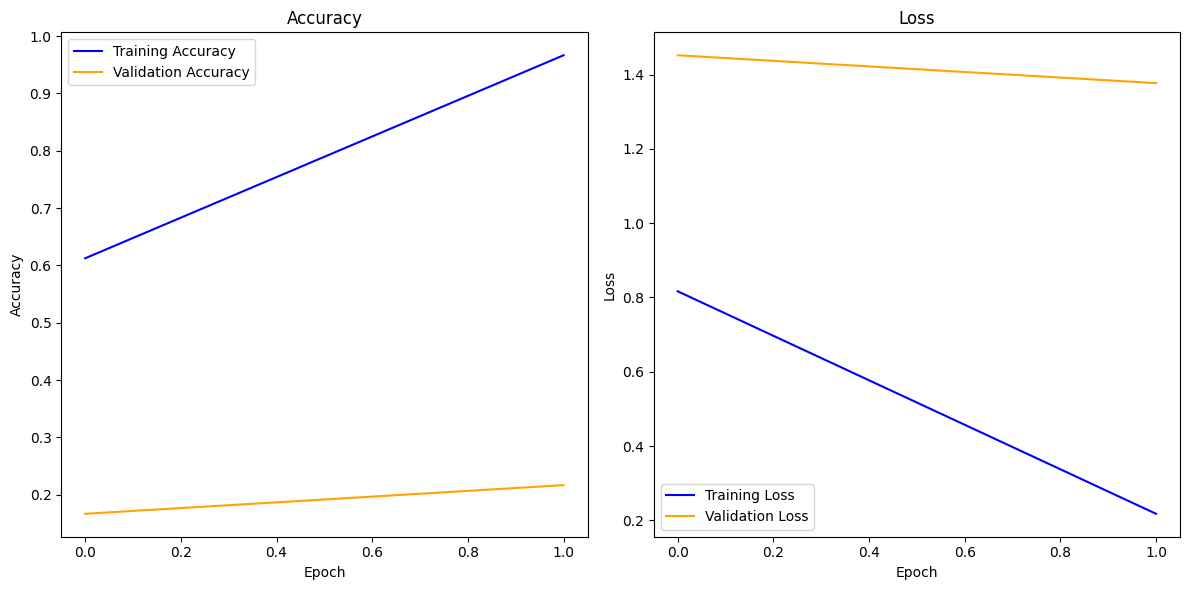

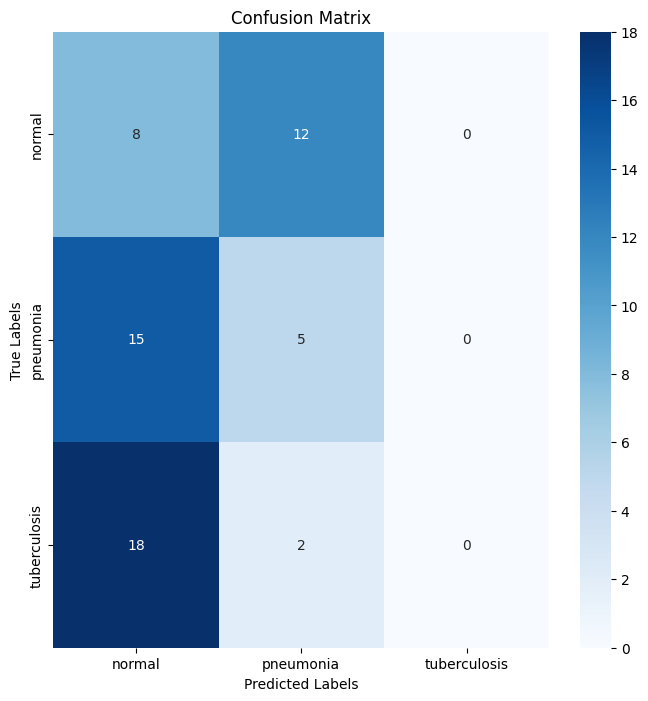

Classification Report for InceptionV3:
              precision    recall  f1-score   support

      normal       0.20      0.40      0.26        20
   pneumonia       0.26      0.25      0.26        20
tuberculosis       0.00      0.00      0.00        20

    accuracy                           0.22        60
   macro avg       0.15      0.22      0.17        60
weighted avg       0.15      0.22      0.17        60



c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [13]:
from keras.applications import InceptionV3

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define top layers for the model
inception_top = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Combine base model with top layers
inception_model = tf.keras.Model(inputs=inception_model.input, outputs=inception_top(inception_model.output))

# Build optimizer with the full list of trainable variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Compile InceptionV3 model with the built optimizer
inception_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train InceptionV3 model with early stopping
history_inception = inception_model.fit(train_dataset, validation_data=valid_dataset, batch_size=BATCH_SIZE, verbose=True, epochs=num_epochs, callbacks=[early_stopping])

# Evaluate InceptionV3 model
true_labels_inception, predicted_labels_inception = evaluate_model(inception_model, valid_dataset)
accuracy_inception = accuracy_score(true_labels_inception, predicted_labels_inception)
print("InceptionV3 Accuracy:", accuracy_inception)

# Plot history metrics for InceptionV3
plot_history_metrics(history_inception)

# Plot confusion matrix for InceptionV3
plot_confusion_matrix(true_labels_inception, predicted_labels_inception, CLASSES)

# Display classification report for InceptionV3
print("Classification Report for InceptionV3:")
print(classification_report(true_labels_inception, predicted_labels_inception, target_names=CLASSES))


In [ ]:
import matplotlib.pyplot as plt

# Convert accuracies to percentages
accuracy_alexnet_percent = accuracy_alexnet * 100
accuracy_densenet_percent = accuracy_densenet * 100
accuracy_inception_percent = accuracy_inception * 100
accuracy_resnet_percent = accuracy_resnet * 100
accuracy_vgg_percent = accuracy_vgg * 100

# Print accuracy for each model in percentage
print(f"AlexNet Accuracy: {accuracy_alexnet_percent:.2f}%")
print(f"DenseNet121 Accuracy: {accuracy_densenet_percent:.2f}%")
print(f"InceptionV3 Accuracy: {accuracy_inception_percent:.2f}%")
print(f"ResNet50 Accuracy: {accuracy_resnet_percent:.2f}%")
print(f"VGG16 Accuracy: {accuracy_vgg_percent:.2f}%")

# Plotting the accuracies
models = ['AlexNet', 'DenseNet121', 'InceptionV3', 'ResNet50', 'VGG16']
accuracies = [accuracy_alexnet_percent, accuracy_densenet_percent, accuracy_inception_percent, accuracy_resnet_percent, accuracy_vgg_percent]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Ensemble

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the names of the models
model_names = ["AlexNet", "DenseNet121", "InceptionV3", "ResNet50", "VGG16"]

# Print accuracies of all 5 models
for i, (model, name) in enumerate(zip(top_models[:3], model_names[:3]), start=1):
    accuracy = model.evaluate(valid_dataset)[1]
    print(f"Accuracy of Model {i} ({name}): {accuracy:.4f}")

In [ ]:
# Select top 3 models
top3_models = top_models[:3]

# Combine predictions of the top 3 models by averaging
def ensemble_predict(image, models):
    predictions = [model.predict(np.expand_dims(image, axis=0)) for model in models]
    return np.mean(predictions, axis=0)

In [ ]:
# Load and preprocess the image
image_path = "E:/chexscan/exp/test/pneumonia.jpeg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image = cv2.resize(image, (299, 299))  # Resize to the required input size
image = image / 255.0  # Normalize the pixel values

# Get ensemble predictions for the image
ensemble_predictions = ensemble_predict(image, top3_models)

# Display the ensemble predictions for the image
for class_index, class_name in enumerate(CLASSES):
    print(f"Ensemble Prediction for class '{class_name}': {ensemble_predictions[0][class_index]:.2f}")

# Convert predictions to class labels
predicted_class_indices = np.argmax(ensemble_predictions, axis=1)
predicted_class_names = [CLASSES[i] for i in predicted_class_indices]

In [ ]:
# Define the input shape based on your models
input_shape = (299, 299, 3)  # Example input shape for RGB images of size 299x299

# Define inputs for the ensemble model
ensemble_inputs = [Input(shape=input_shape) for _ in range(len(top3_models))]

# Get outputs of the top 3 models
model_outputs = [model(inputs) for model, inputs in zip(top3_models, ensemble_inputs)]

# Average the outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=ensemble_inputs, outputs=ensemble_output)

# Compile the ensemble model (if needed)
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import joblib

# Save the ensemble model using joblib
ensemble_model_path = "ensemble_model_01.pkl"
joblib.dump(ensemble_model, ensemble_model_path)


# Make predictions using the ensemble model
predictions = ensemble_model.predict(input_image)

# Extract class names and corresponding probabilities
class_names = ["normal", "pneumonia", "tuberculosis"]  # Replace with your actual class names
probabilities = predictions[0]

# Sort the probabilities in descending order
sorted_indices = np.argsort(probabilities)[::-1]

# Display the top predicted class and its confidence
top_class = class_names[sorted_indices[0]]
top_confidence = probabilities[sorted_indices[0]]
print(f"Top predicted class: {top_class}, Confidence: {top_confidence:.2f}")

# Display the next two predicted classes and their confidences
for i in range(1, 3):
    class_name = class_names[sorted_indices[i]]
    confidence = probabilities[sorted_indices[i]]
    print(f"Predicted class {i+1}: {class_name}, Confidence: {confidence:.2f}")
